In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from shutil import copyfile
fileList = ['cardata1.zip','cardata1.csv', 'cardata2.zip','cardata2.csv','cardata3.zip', 'cardata3.csv','cardata4.zip','cardata4.csv','cardata_t2.zip', 'cardata_t2.csv']
for name in fileList:  
  src = '/content/gdrive/My Drive/ML_Data/Selfdriving/cardata/' + name
  dst = '/content/sample_data/' + name
  copyfile(src, dst)


In [0]:
import csv
import cv2
import numpy as np
import zipfile
import random
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt


In [0]:
import zipfile
archive = zipfile.ZipFile('/content/sample_data/cardata4.zip', 'r')


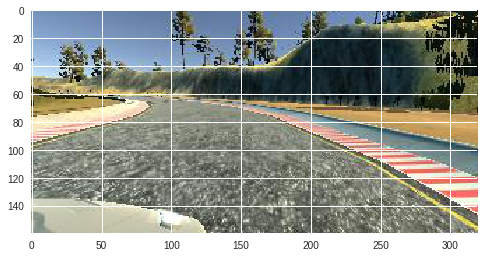

In [5]:
imgfile = archive.open('right_2018_11_16_11_04_58_748.jpg')
from PIL import Image
img = Image.open(imgfile)
plt.imshow(img)

In [0]:
correction = 0.25
measurements = []
images = []
outputFile = 'model_t2_'
fileCounter = 0

In [0]:
def load_image(archive, name):
  imgfile = archive.open(name.split("/")[-1])
  img = Image.open(imgfile)
  return np.array(img)


def readData(name, images, measurements, correction):
  lines = []

  with open('/content/sample_data/'+name+'.csv') as csvfile:
      reader = csv.reader(csvfile)
      for line in reader:
          lines.append(line)
  archive = zipfile.ZipFile('/content/sample_data/'+name+'.zip', 'r')
  

  
  for i in tqdm(range(len(lines))):
    line = lines[i]
    steering_center = float(line[3])
    steering_left = steering_center + correction
    steering_right = steering_center - correction
    image_center = load_image(archive, line[0])
    image_left = load_image(archive, line[1])
    image_right = load_image(archive, line[2])
    images.extend([image_center, image_left, image_right])
    measurements.extend([steering_center, steering_left, steering_right])
    #images.extend([np.fliplr(image_center),np.fliplr(image_left), np.fliplr(image_right)])
    #measurements.extend([steering_center * -1.0, steering_left* -1.0, steering_right* -1.0])
  

In [8]:
readData('cardata_t2',images, measurements,correction)


100%|██████████| 7773/7773 [00:34<00:00, 227.99it/s]


In [0]:
#readData('cardata2',images, measurements,correction)


In [0]:
#readData('cardata3',images, measurements,correction)

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, MaxPooling2D, Cropping2D, Dropout, Activation
from keras.layers.normalization import BatchNormalization


model = Sequential()
model.add(Lambda(lambda x: (x / 127.5) - 1, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((75,15), (0,0))))

model.add(Conv2D(24,5,strides=(2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(36,5,strides=(2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(48,5,strides=(2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(Conv2D(64,3))
model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(Conv2D(64,3))
model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dropout(0.5))
model.add(Dense(8))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

Using TensorFlow backend.


In [0]:
#most of the image functions come from:
#https://medium.freecodecamp.org/image-augmentation-make-it-rain-make-it-snow-how-to-modify-a-photo-with-machine-learning-163c0cb3843f
def add_brightness(image):
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    image_HLS = np.array(image_HLS, dtype = np.float64) 
    random_brightness_coefficient = np.random.uniform()*1.6+0.2 ## generates value between 0.5 and 1.5
    image_HLS[:,:,1] = image_HLS[:,:,1]*random_brightness_coefficient ## scale pixel values up or down for channel 1(Lightness)
    image_HLS[:,:,1][image_HLS[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
    image_HLS = np.array(image_HLS, dtype = np.uint8)
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

def generate_shadow_coordinates(imshape, no_of_shadows=1):
    vertices_list=[]
    for index in range(no_of_shadows):
        vertex=[]
        for dimensions in range(np.random.randint(3,15)): ## Dimensionality of the shadow polygon
            vertex.append(( imshape[1]*np.random.uniform(),imshape[0]//3+imshape[0]*np.random.uniform()))
        vertices = np.array([vertex], dtype=np.int32) ## single shadow vertices 
        vertices_list.append(vertices)
    return vertices_list ## List of shadow vertices

def add_shadow(image, no_of_shadows=1):
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    mask = np.zeros_like(image) 
    imshape = image.shape
    vertices_list= generate_shadow_coordinates(imshape, no_of_shadows) #3 getting list of shadow vertices
    for vertices in vertices_list: 
        cv2.fillPoly(mask, vertices, 255) ## adding all shadow polygons on empty mask, single 255 denotes only red channel
    
    image_HLS[:,:,1][mask[:,:,0]==255] = image_HLS[:,:,1][mask[:,:,0]==255]*0.5   ## if red channel is hot, image's "Lightness" channel's brightness is lowered 
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB  
  
  
def mirror(image, angle):
  if random.random() > 0.5:
     return (np.fliplr(image), angle * -1)
  return image, angle
  

1


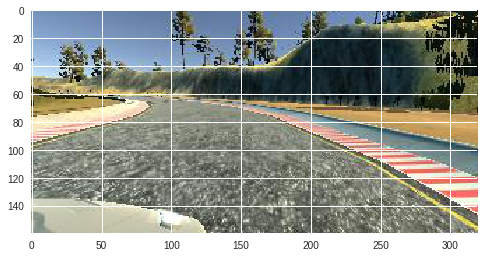

In [12]:
#mirror test
m_img, steer = mirror(img,1)
print(steer)
plt.imshow(m_img)


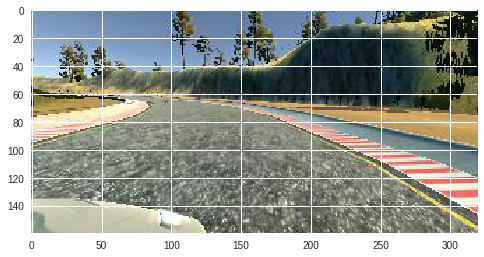

In [13]:
plt.imshow(add_shadow(np.array(img),no_of_shadows=0))

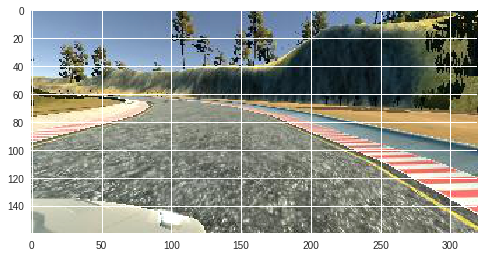

In [14]:
plt.imshow(add_brightness(np.array(img)))

In [0]:
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import sklearn
import itertools



#def load_image(source_path):
#    filename = source_path.split('/')[-1]
#    current_path = '/content/gdrive/My Drive/ML_Data/Selfdriving/cardata/IMG/' + filename 
#    return cv2.imread(current_path)

def generator(samples, measures, batch_size=32):
    num_samples = len(samples)
    #augmented_samples = list(itertools.product(samples, [aug for aug in Augmentation]))
    while 1: # Loop forever so the generator never terminates
        _samples,_measures = sklearn.utils.shuffle(samples, measures)

        for offset in range(0, num_samples, batch_size):
            images = _samples[offset:offset+batch_size]
            angles = _measures[offset:offset+batch_size]
            for i in range(len(images)):
              image = images[i]
              angle = angles[i]
              image,angle = mirror(image, angle)
              image = add_brightness(image)
              image = add_shadow(image, random.randint(0,1))
              
              images[i] = image
              angles[i] = angle
                  
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield X_train, y_train


In [0]:
import matplotlib.pyplot as plt

def plot_history(history_object):
    ### print the keys contained in the history object
    print(history_object.history.keys())

    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

In [0]:
sklearn.utils.shuffle(images, measurements)
train_samples, validation_samples, train_measures, validation_measures = train_test_split(images, measurements, test_size=0.2)

batch_size = 256
train_generator = generator(train_samples, train_measures, batch_size=batch_size)
validation_generator = generator(validation_samples, validation_measures, batch_size=batch_size)


Timestamp: 2018-11-17 20:21:22
Epoch 1/20
73/72 [==============================] - 69s 940ms/step - loss: 10.1095 - val_loss: 0.2805
Epoch 2/20
73/72 [==============================] - 60s 818ms/step - loss: 0.8480 - val_loss: 0.2707
Epoch 3/20
73/72 [==============================] - 61s 831ms/step - loss: 0.6225 - val_loss: 0.2637
Epoch 4/20
73/72 [==============================] - 60s 818ms/step - loss: 0.5180 - val_loss: 0.2632
Epoch 5/20
73/72 [==============================] - 61s 829ms/step - loss: 0.4595 - val_loss: 0.2572
Epoch 6/20
73/72 [==============================] - 61s 833ms/step - loss: 0.4345 - val_loss: 0.2562
Epoch 7/20
73/72 [==============================] - 61s 834ms/step - loss: 0.4110 - val_loss: 0.2587
Epoch 8/20
73/72 [==============================] - 62s 843ms/step - loss: 0.3989 - val_loss: 0.2489
Epoch 9/20
73/72 [==============================] - 61s 834ms/step - loss: 0.3776 - val_loss: 0.2575
Epoch 10/20
73/72 [==============================] - 61s 83

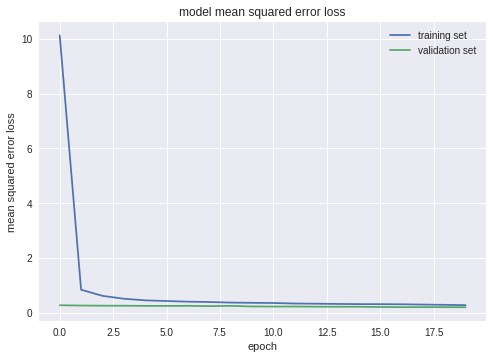

TypeError: ignored

In [18]:
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
history_object = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_samples)/batch_size, 
    validation_data=validation_generator,
    validation_steps = len(validation_samples)/batch_size, 
    epochs=20, 
    verbose=1
)


plot_history(history_object)
fileCounter += 1
model.save('/content/gdrive/My Drive/ML_Data/Selfdriving/cardata/'+outputFile+fileCounter+'.h5')

Timestamp: 2018-11-17 16:08:21
Epoch 1/5
60/59 [==============================] - 53s 875ms/step - loss: 0.1673 - val_loss: 0.1023
Epoch 2/5
60/59 [==============================] - 51s 845ms/step - loss: 0.1664 - val_loss: 0.1010
Epoch 3/5
60/59 [==============================] - 51s 848ms/step - loss: 0.1648 - val_loss: 0.0997
Epoch 4/5
60/59 [==============================] - 51s 843ms/step - loss: 0.1564 - val_loss: 0.0993
Epoch 5/5
60/59 [==============================] - 51s 849ms/step - loss: 0.1516 - val_loss: 0.0977
dict_keys(['val_loss', 'loss'])


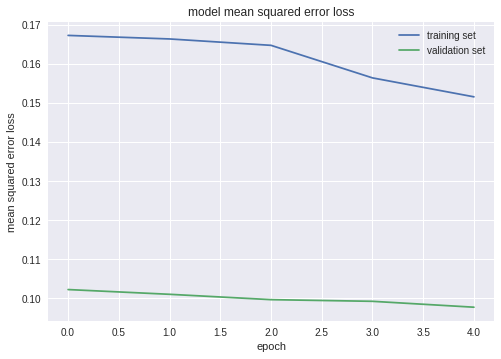

In [29]:
train_generator = generator(train_samples, train_measures, batch_size=batch_size)
validation_generator = generator(validation_samples, validation_measures, batch_size=batch_size)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
history_object = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_samples)/batch_size, 
    validation_data=validation_generator,
    validation_steps = len(validation_samples)/batch_size, 
    epochs=20, 
    verbose=1
)


plot_history(history_object)
fileCounter += 1
model.save('/content/gdrive/My Drive/ML_Data/Selfdriving/cardata/'+outputFile+fileCounter+'.h5')

Timestamp: 2018-11-17 16:28:37
Epoch 1/20
60/59 [==============================] - 53s 888ms/step - loss: 0.1474 - val_loss: 0.0958
Epoch 2/20
60/59 [==============================] - 50s 832ms/step - loss: 0.1496 - val_loss: 0.0961
Epoch 3/20
60/59 [==============================] - 51s 845ms/step - loss: 0.1431 - val_loss: 0.0978
Epoch 4/20
60/59 [==============================] - 51s 849ms/step - loss: 0.1441 - val_loss: 0.0943
Epoch 5/20
60/59 [==============================] - 50s 830ms/step - loss: 0.1365 - val_loss: 0.0947
Epoch 6/20
60/59 [==============================] - 51s 846ms/step - loss: 0.1364 - val_loss: 0.0940
Epoch 7/20
60/59 [==============================] - 51s 842ms/step - loss: 0.1372 - val_loss: 0.0932
Epoch 8/20
60/59 [==============================] - 50s 837ms/step - loss: 0.1345 - val_loss: 0.0923
Epoch 9/20
60/59 [==============================] - 50s 835ms/step - loss: 0.1298 - val_loss: 0.0941
Epoch 10/20
60/59 [==============================] - 51s 850

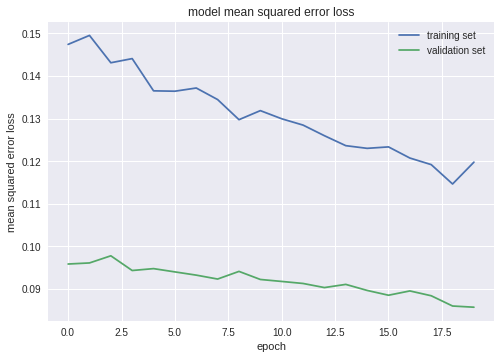

In [30]:
train_generator = generator(train_samples, train_measures, batch_size=batch_size)
validation_generator = generator(validation_samples, validation_measures, batch_size=batch_size)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
history_object = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_samples)/batch_size, 
    validation_data=validation_generator,
    validation_steps = len(validation_samples)/batch_size, 
    epochs=20, 
    verbose=1
)

plot_history(history_object)
fileCounter += 1
model.save('/content/gdrive/My Drive/ML_Data/Selfdriving/cardata/'+outputFile+fileCounter+'.h5')

Timestamp: 2018-11-17 16:45:48
Epoch 1/20
60/59 [==============================] - 52s 865ms/step - loss: 0.1137 - val_loss: 0.0850
Epoch 2/20
60/59 [==============================] - 49s 824ms/step - loss: 0.1110 - val_loss: 0.0868
Epoch 3/20
60/59 [==============================] - 50s 833ms/step - loss: 0.1101 - val_loss: 0.0843
Epoch 4/20
60/59 [==============================] - 49s 816ms/step - loss: 0.1110 - val_loss: 0.0837
Epoch 5/20
60/59 [==============================] - 49s 813ms/step - loss: 0.1092 - val_loss: 0.0824
Epoch 6/20
60/59 [==============================] - 49s 819ms/step - loss: 0.1094 - val_loss: 0.0840
Epoch 7/20
60/59 [==============================] - 49s 820ms/step - loss: 0.1076 - val_loss: 0.0818
Epoch 8/20
60/59 [==============================] - 49s 825ms/step - loss: 0.1071 - val_loss: 0.0813
Epoch 9/20
60/59 [==============================] - 49s 821ms/step - loss: 0.1047 - val_loss: 0.0807
Epoch 10/20
60/59 [==============================] - 50s 828

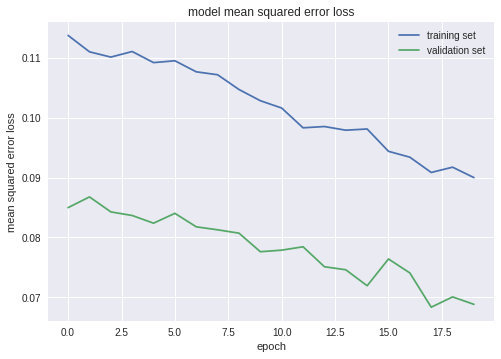

In [31]:
train_generator = generator(train_samples, train_measures, batch_size=batch_size)
validation_generator = generator(validation_samples, validation_measures, batch_size=batch_size)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
history_object = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_samples)/batch_size, 
    validation_data=validation_generator,
    validation_steps = len(validation_samples)/batch_size, 
    epochs=20, 
    verbose=1
)

plot_history(history_object)
fileCounter += 1
model.save('/content/gdrive/My Drive/ML_Data/Selfdriving/cardata/'+outputFile+fileCounter+'.h5')

Timestamp: 2018-11-17 17:02:28
Epoch 1/20
60/59 [==============================] - 53s 881ms/step - loss: 0.0899 - val_loss: 0.0687
Epoch 2/20
60/59 [==============================] - 49s 815ms/step - loss: 0.0875 - val_loss: 0.0641
Epoch 3/20
60/59 [==============================] - 49s 824ms/step - loss: 0.0864 - val_loss: 0.0685
Epoch 4/20
60/59 [==============================] - 50s 835ms/step - loss: 0.0851 - val_loss: 0.0663
Epoch 5/20
60/59 [==============================] - 51s 844ms/step - loss: 0.0835 - val_loss: 0.0672
Epoch 6/20
60/59 [==============================] - 51s 845ms/step - loss: 0.0833 - val_loss: 0.0647
Epoch 7/20
60/59 [==============================] - 50s 831ms/step - loss: 0.0820 - val_loss: 0.0625
Epoch 8/20
60/59 [==============================] - 50s 829ms/step - loss: 0.0816 - val_loss: 0.0623
Epoch 9/20
60/59 [==============================] - 50s 836ms/step - loss: 0.0796 - val_loss: 0.0629
Epoch 10/20
60/59 [==============================] - 50s 832

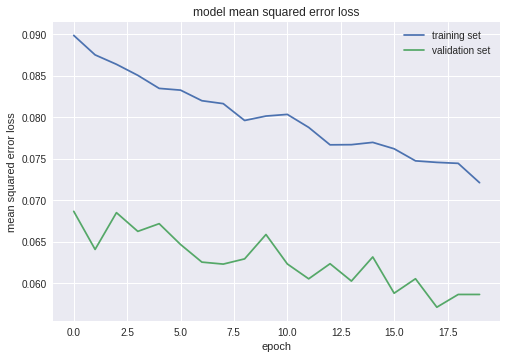

In [32]:
train_generator = generator(train_samples, train_measures, batch_size=batch_size)
validation_generator = generator(validation_samples, validation_measures, batch_size=batch_size)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
history_object = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_samples)/batch_size, 
    validation_data=validation_generator,
    validation_steps = len(validation_samples)/batch_size, 
    epochs=20, 
    verbose=1
)

plot_history(history_object)
fileCounter += 1
model.save('/content/gdrive/My Drive/ML_Data/Selfdriving/cardata/'+outputFile+fileCounter+'.h5')

Timestamp: 2018-11-17 17:19:22
Epoch 1/20
60/59 [==============================] - 53s 889ms/step - loss: 0.0725 - val_loss: 0.0585
Epoch 2/20
60/59 [==============================] - 50s 837ms/step - loss: 0.0719 - val_loss: 0.0566
Epoch 3/20
60/59 [==============================] - 50s 838ms/step - loss: 0.0721 - val_loss: 0.0565
Epoch 4/20
60/59 [==============================] - 51s 846ms/step - loss: 0.0725 - val_loss: 0.0598
Epoch 5/20
60/59 [==============================] - 51s 850ms/step - loss: 0.0697 - val_loss: 0.0559
Epoch 6/20
60/59 [==============================] - 50s 833ms/step - loss: 0.0698 - val_loss: 0.0529
Epoch 7/20
60/59 [==============================] - 50s 841ms/step - loss: 0.0696 - val_loss: 0.0597
Epoch 8/20
60/59 [==============================] - 51s 845ms/step - loss: 0.0721 - val_loss: 0.0572
Epoch 9/20
60/59 [==============================] - 51s 858ms/step - loss: 0.0676 - val_loss: 0.0580
Epoch 10/20
60/59 [==============================] - 51s 850

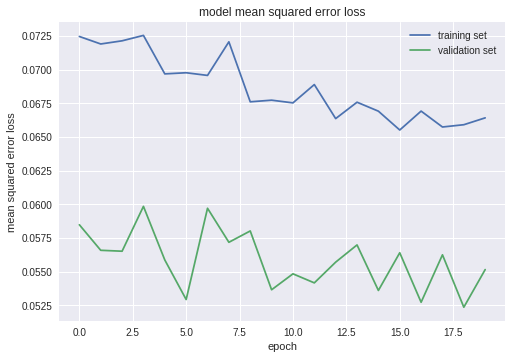

In [33]:
train_generator = generator(train_samples, train_measures, batch_size=batch_size)
validation_generator = generator(validation_samples, validation_measures, batch_size=batch_size)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
history_object = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_samples)/batch_size, 
    validation_data=validation_generator,
    validation_steps = len(validation_samples)/batch_size, 
    epochs=20, 
    verbose=1
)

plot_history(history_object)
fileCounter += 1
model.save('/content/gdrive/My Drive/ML_Data/Selfdriving/cardata/'+outputFile+fileCounter+'.h5')

Timestamp: 2018-11-17 17:36:48
Epoch 1/20
60/59 [==============================] - 53s 890ms/step - loss: 0.0644 - val_loss: 0.0554
Epoch 2/20
60/59 [==============================] - 51s 849ms/step - loss: 0.0648 - val_loss: 0.0530
Epoch 3/20
60/59 [==============================] - 51s 850ms/step - loss: 0.0657 - val_loss: 0.0531
Epoch 4/20
60/59 [==============================] - 51s 842ms/step - loss: 0.0658 - val_loss: 0.0527
Epoch 5/20
60/59 [==============================] - 51s 844ms/step - loss: 0.0639 - val_loss: 0.0558
Epoch 6/20
60/59 [==============================] - 51s 849ms/step - loss: 0.0640 - val_loss: 0.0526
Epoch 7/20
60/59 [==============================] - 51s 850ms/step - loss: 0.0639 - val_loss: 0.0566
Epoch 8/20
60/59 [==============================] - 51s 858ms/step - loss: 0.0637 - val_loss: 0.0517
Epoch 9/20
60/59 [==============================] - 51s 852ms/step - loss: 0.0619 - val_loss: 0.0554
Epoch 10/20
60/59 [==============================] - 51s 857

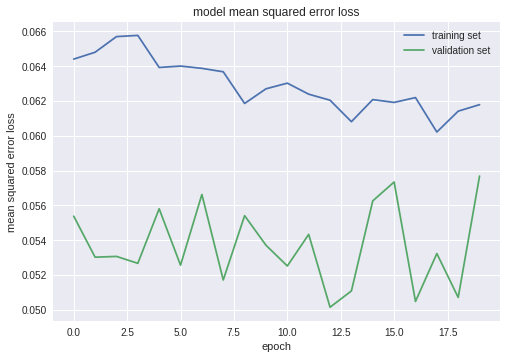

In [34]:
train_generator = generator(train_samples, train_measures, batch_size=batch_size)
validation_generator = generator(validation_samples, validation_measures, batch_size=batch_size)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
history_object = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_samples)/batch_size, 
    validation_data=validation_generator,
    validation_steps = len(validation_samples)/batch_size, 
    epochs=20, 
    verbose=1
)

plot_history(history_object)
fileCounter += 1
model.save('/content/gdrive/My Drive/ML_Data/Selfdriving/cardata/'+outputFile+fileCounter+'.h5')

Timestamp: 2018-11-17 17:58:50
Epoch 1/20
60/59 [==============================] - 54s 895ms/step - loss: 0.0603 - val_loss: 0.0535
Epoch 2/20
60/59 [==============================] - 51s 855ms/step - loss: 0.0612 - val_loss: 0.0503
Epoch 3/20
60/59 [==============================] - 51s 849ms/step - loss: 0.0596 - val_loss: 0.0526
Epoch 4/20
60/59 [==============================] - 51s 852ms/step - loss: 0.0594 - val_loss: 0.0523
Epoch 5/20
60/59 [==============================] - 51s 852ms/step - loss: 0.0610 - val_loss: 0.0508
Epoch 6/20
60/59 [==============================] - 52s 859ms/step - loss: 0.0586 - val_loss: 0.0535
Epoch 7/20
60/59 [==============================] - 51s 851ms/step - loss: 0.0615 - val_loss: 0.0516
Epoch 8/20
60/59 [==============================] - 52s 860ms/step - loss: 0.0590 - val_loss: 0.0522
Epoch 9/20
60/59 [==============================] - 51s 853ms/step - loss: 0.0605 - val_loss: 0.0503
Epoch 10/20
60/59 [==============================] - 51s 858

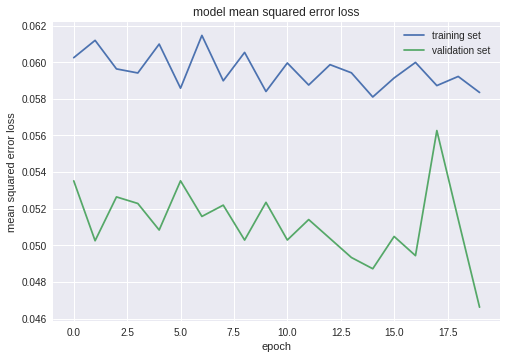

In [35]:
train_generator = generator(train_samples, train_measures, batch_size=batch_size)
validation_generator = generator(validation_samples, validation_measures, batch_size=batch_size)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
history_object = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_samples)/batch_size, 
    validation_data=validation_generator,
    validation_steps = len(validation_samples)/batch_size, 
    epochs=20, 
    verbose=1
)

plot_history(history_object)
fileCounter += 1
model.save('/content/gdrive/My Drive/ML_Data/Selfdriving/cardata/'+outputFile+fileCounter+'.h5')